In [7]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
from scipy.signal import welch
from scipy.signal import butter, sosfilt
import os

if not os.path.exists('plots'):
    os.makedirs('plots')

In [2]:
def normalize_audio(audio_data):
    """Scales audio to [-1.0, 1.0] to prevent clipping and ensure consistent PSD."""
    audio_float = audio_data.astype(float)
    max_val = np.max(np.abs(audio_float))
    return audio_float / max_val if max_val > 0 else audio_float

In [3]:
def get_psd_feature(signal, fs):
    """
    Calculates Power Spectral Density (PSD) using Welch's method.
    Returns the log-mean power in the speech frequency band (300Hz - 3000Hz).
    """
    frequencies, psd = welch(signal, fs, nperseg=1024)
    
    idx_speech_band = np.where((frequencies >= 300) & (frequencies <= 3000))[0]
    
    mean_psd = np.mean(psd[idx_speech_band])
    return np.log10(mean_psd + 1e-12)

In [4]:
def calculate_threshold(speech_folder, music_folder):
    """Analyzes folders to find the average PSD difference between Speech and Music."""
    s_files = [os.path.join(speech_folder, f) for f in os.listdir(speech_folder) if f.endswith('.wav')]
    m_files = [os.path.join(music_folder, f) for f in os.listdir(music_folder) if f.endswith('.wav')]

    
    s_feats = []
    for f in s_files[:15]:
        fs, data = wav.read(f)
        if len(data.shape) > 1: data = data[:, 0]
        s_feats.append(get_psd_feature(normalize_audio(data), fs))

    m_feats = []
    for f in m_files[:15]:
        fs, data = wav.read(f)
        if len(data.shape) > 1: data = data[:, 0]
        m_feats.append(get_psd_feature(normalize_audio(data), fs))

    
    threshold = (np.mean(s_feats) + np.mean(m_feats)) / 2
    print(f"--- Training Complete ---")
    print(f"Speech Avg PSD: {np.mean(s_feats):.4f} | Music Avg PSD: {np.mean(m_feats):.4f}")
    print(f"Calculated Threshold: {threshold:.4f}")
    return threshold

SPEECH_DIR = './data/speech_wav/'
MUSIC_DIR = './data/music_wav/'

my_threshold = calculate_threshold(SPEECH_DIR, MUSIC_DIR)

--- Training Complete ---
Speech Avg PSD: -5.6106 | Music Avg PSD: -5.3369
Calculated Threshold: -5.4738


In [5]:
def smooth_log(log, window_size=5):
    """
    Applies a moving average filter to the detection log.
    """
    # Use a simple moving average filter
    return np.convolve(log, np.ones(window_size)/window_size, mode='same')

In [19]:
def process_audio_pro_studio(mixed_signal, music_layer, speech_layer, threshold, fs):
    """
    Enhanced Studio Logic with Smoothing for transitions.
    """
    frame_size = int(0.1 * fs) 
    num_frames = len(mixed_signal) // frame_size
    output = np.zeros_like(mixed_signal)
    
    # Raw Detection
    raw_logs = []
    for i in range(num_frames):
        start_idx = i * frame_size
        mix_frame = mixed_signal[start_idx : start_idx + frame_size]
        current_psd = get_psd_feature(mix_frame, fs)
        raw_logs.append(1 if current_psd > threshold else 0)
    
    # Smoothing the detection log (Fade transitions)
    smoothed_logs = smooth_log(raw_logs, window_size=5)

    # Applying the smoothed gains
    for i in range(num_frames):
        start_idx = i * frame_size
        end_idx = start_idx + frame_size
        
        # S_gain: 0 to 1 (Speech volume)
        # M_gain: 1 down to 0.2 (Music ducking)
        s_gain = smoothed_logs[i]
        m_gain = 1.0 - (0.94 * smoothed_logs[i])
        
        output[start_idx : end_idx] = (speech_layer[start_idx : end_idx] * s_gain) + \
                                      (music_layer[start_idx : end_idx] * m_gain)
            
    return output, smoothed_logs

In [ ]:
def calculate_rms(signal):
    """Calculates Root Mean Square (energy) of the signal."""
    return np.sqrt(np.mean(signal**2))

def match_loudness(target_signal, ref_signal):
    """
    Adjusts target_signal gain to match the RMS of ref_signal.
    """
    rms_ref = calculate_rms(ref_signal)
    rms_target = calculate_rms(target_signal)
    
    if rms_target == 0: return target_signal
    
    # Calculate gain ratio
    gain = rms_ref / rms_target
    return target_signal * gain

def butter_band_filter(data, lowcut, highcut, fs, order=4, btype='band'):
    """Generic Butterworth filter wrapper using SOS for stability."""
    nyq = 0.5 * fs
    
    if btype == 'low':
        normal_cutoff = lowcut / nyq
        sos = butter(order, normal_cutoff, btype='low', analog=False, output='sos')
    elif btype == 'high':
        normal_cutoff = highcut / nyq
        sos = butter(order, normal_cutoff, btype='high', analog=False, output='sos')
    else: # bandpass
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], btype='band', analog=False, output='sos')
        
    return sosfilt(sos, data)

def apply_3band_eq(audio, fs, gains_db):
    """
    Applies a 3-band equalizer (Low, Mid, High).
    gains_db: Tuple of (low_db, mid_db, high_db)
    """
    low_gain, mid_gain, high_gain = [10**(g/20) for g in gains_db]
    
    # Low Band (< 300Hz) - Bass
    low_band = butter_band_filter(audio, 300, None, fs, btype='low')
    
    # Mid Band (300Hz - 4000Hz) - Speech Intelligibility
    mid_band = butter_band_filter(audio, 300, 4000, fs, btype='band')
    
    # High Band (> 4000Hz) - Air/Treble
    high_band = butter_band_filter(audio, None, 4000, fs, btype='high')
    
    # Combine with gains
    equalized_signal = (low_band * low_gain) + \
                       (mid_band * mid_gain) + \
                       (high_band * high_gain)
                       
    return equalized_signal


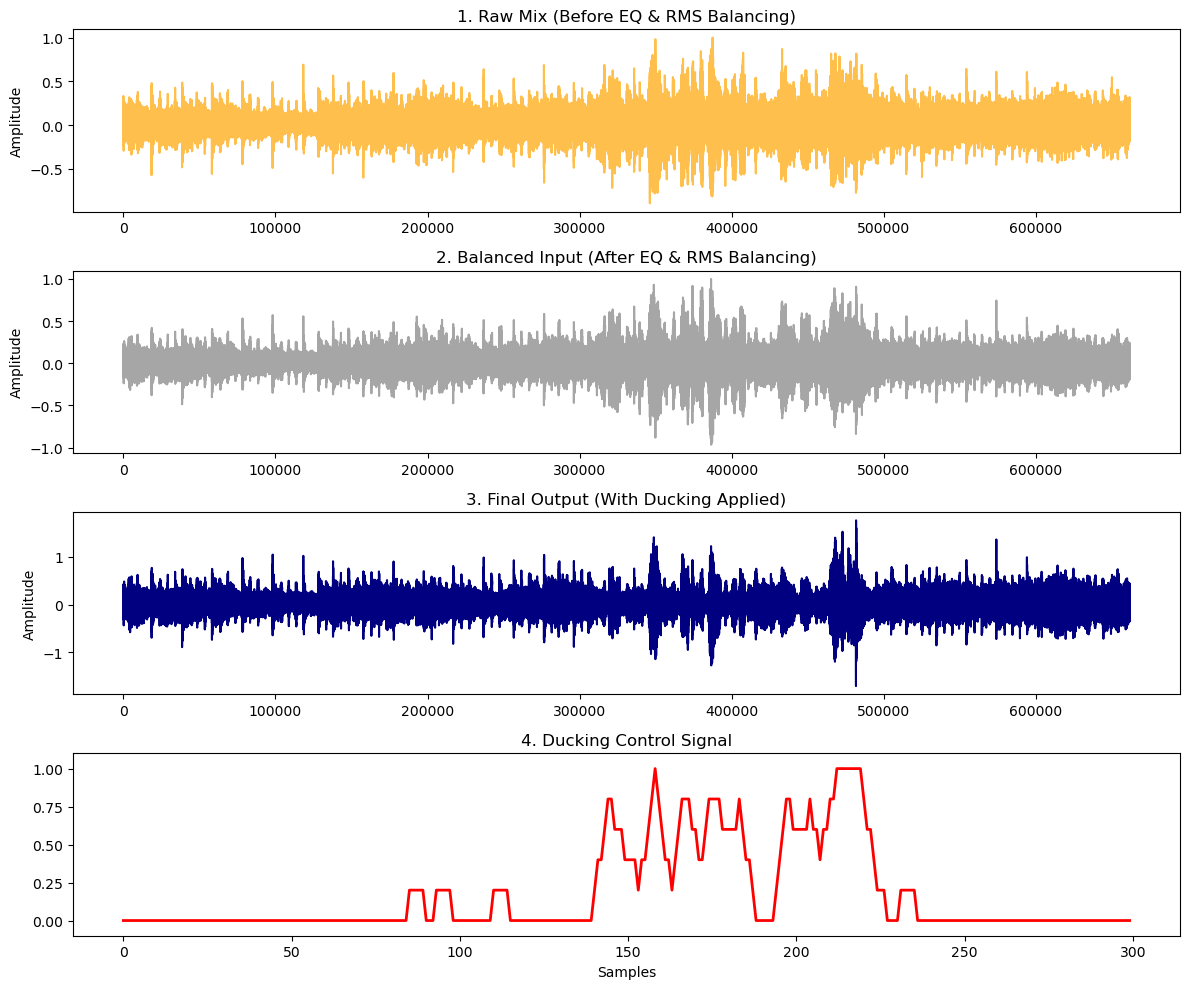

In [ ]:
# Load and Normalize
fs_s, s_raw = wav.read(os.path.join(SPEECH_DIR, os.listdir(SPEECH_DIR)[0]))
fs_m, m_raw = wav.read(os.path.join(MUSIC_DIR, os.listdir(MUSIC_DIR)[0]))

# Ensure lengths match
length = min(len(s_raw), len(m_raw))
m_layer_raw = normalize_audio(m_raw[:length])
s_layer_raw = np.zeros(length)

# Place speech in the middle
mid_start, mid_end = length // 4, 3 * length // 4
s_layer_raw[mid_start : mid_end] = normalize_audio(s_raw[:lesngth])[mid_start : mid_end]

# Create Raw Mix for Comparison
raw_mix = normalize_audio(m_layer_raw + s_layer_raw)

# Equalizer Settings
# Speech: Boost Mids slightly for clarity (+2dB)
# Music: Cut Mids slightly (-3dB) to make room for speech
# (Assumes apply_3band_eq function is defined from previous step)
s_layer_eq = apply_3band_eq(s_layer_raw, fs_s, gains_db=(0, 2, 0))
m_layer_eq = apply_3band_eq(m_layer_raw, fs_m, gains_db=(0, -3, 0))

# RMS Leveling
# We want the music to generally match the speech loudness before ducking applies
# (Assumes match_loudness function is defined from previous step)
m_layer_balanced = match_loudness(target_signal=m_layer_eq, ref_signal=s_layer_eq[mid_start:mid_end])

# Create the Balanced Mix
mixed_input = normalize_audio(m_layer_balanced + s_layer_eq)

# Process with Ducking Logic
final_audio, s_log = process_audio_pro_studio(mixed_input, m_layer_balanced, s_layer_eq, my_threshold, fs_s)

# Save and Plot
wav.write('output_equalized.wav', fs_s, (normalize_audio(final_audio) * 32767).astype(np.int16))

plt.figure(figsize=(12, 10))

# Subplot 1: Raw Mix (No EQ, No Leveling)
plt.subplot(4, 1, 1)
plt.plot(raw_mix, color='orange', alpha=0.7)
plt.title("1. Raw Mix (Before EQ & RMS Balancing)")
plt.ylabel("Amplitude")

# Subplot 2: Balanced Mix (EQ + RMS Leveling applied)
plt.subplot(4, 1, 2)
plt.plot(mixed_input, color='gray', alpha=0.7)
plt.title("2. Balanced Input (After EQ & RMS Balancing)")
plt.ylabel("Amplitude")

# Subplot 3: Final Output (After Ducking)
plt.subplot(4, 1, 3)
plt.plot(final_audio, color='navy')
plt.title("3. Final Output (With Ducking Applied)")
plt.ylabel("Amplitude")

# Subplot 4: Control Signal
plt.subplot(4, 1, 4)
plt.plot(s_log, color='red', linewidth=2)
plt.title("4. Ducking Control Signal")
plt.ylim([-0.1, 1.1])
plt.xlabel("Samples")

plt.tight_layout()
plt.savefig('plots/result_comparison.png')
plt.show()
